In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import datetime
import sys

print('python version :',sys.version)
print('tensorflow version :',tf.__version__)

np.random.seed(123)
tf.keras.utils.set_random_seed(456)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

python version : 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:40:32) [GCC 12.3.0]
tensorflow version : 2.12.0


# Data Wrangling & Exploration

In [2]:
bike_sharing = pd.read_csv('/kaggle/input/london-bike-sharing-dataset/london_merged.csv')
bike_sharing.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [3]:
bike_sharing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     17414 non-null  object 
 1   cnt           17414 non-null  int64  
 2   t1            17414 non-null  float64
 3   t2            17414 non-null  float64
 4   hum           17414 non-null  float64
 5   wind_speed    17414 non-null  float64
 6   weather_code  17414 non-null  float64
 7   is_holiday    17414 non-null  float64
 8   is_weekend    17414 non-null  float64
 9   season        17414 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.3+ MB


In [4]:
# helper function 

def hours_count(df,sort_by):
    day_hour_df = pd.DataFrame()
    day_hour_df['daydate'] = df.timestamp.dt.date
    day_hour_df['hour'] = df.timestamp.dt.hour
    hours_count = day_hour_df.groupby(by='daydate').agg({'hour':'count'}).reset_index()
    hours_count = hours_count.sort_values(by=sort_by)
    hours_count['missing'] = 24 - hours_count.hour
    print('total missing =',hours_count['missing'].sum())
    return hours_count

In [5]:
bike_sharing.timestamp = pd.to_datetime(bike_sharing.timestamp)
hours_count(bike_sharing, sort_by='hour').head()

total missing = 106


,daydate,hour,missing
537,2016-06-24,9,15
607,2016-09-03,12,12
448,2016-03-27,14,10
282,2015-10-13,18,6
318,2015-11-18,18,6


look like we still have missing data

In [6]:
# adding missing hour
min_datetime = bike_sharing.timestamp.min()
max_datetime = bike_sharing.timestamp.max()
all_datetime = pd.date_range(min_datetime, max_datetime, freq='H')
datetime_df = pd.DataFrame({'timestamp':all_datetime})
new_bike_sharing = pd.merge(datetime_df, bike_sharing, on='timestamp', how='left')

hours_count(new_bike_sharing, sort_by='hour').head()

total missing = 0


,daydate,hour,missing
0,2015-01-04,24,0
482,2016-04-30,24,0
483,2016-05-01,24,0
484,2016-05-02,24,0
485,2016-05-03,24,0


In [7]:
print(f'==== missing values ==== \n{new_bike_sharing.isna().sum()}')
print(f'==== duplicated values ==== \n {new_bike_sharing.timestamp.duplicated().value_counts()}')                          
# new_bike_sharing.sample(10)

==== missing values ==== 
timestamp         0
cnt             130
t1              130
t2              130
hum             130
wind_speed      130
weather_code    130
is_holiday      130
is_weekend      130
season          130
dtype: int64
==== duplicated values ==== 
 False    17544
Name: timestamp, dtype: int64


The missing values for each col should be 106 but the result of `new_bike_sharing.isna().sum()` is 130 each. Probably because there is a totaly missing value in a one day (24 hours)

In [8]:
null_count_df = pd.DataFrame()
null_count_df['daydate'] = new_bike_sharing.timestamp.dt.date
null_count_df['nulls_sum'] = new_bike_sharing.isna().astype(int).sum(axis=1)
null_count_df['missing_hours'] = new_bike_sharing.isna().astype(int).cnt
null_count_df = null_count_df.groupby('daydate').agg('sum').reset_index()
null_count_df.sort_values('nulls_sum', ascending=False).reset_index(drop=True)

,daydate,nulls_sum,missing_hours
0,2016-09-02,216,24
1,2016-06-24,135,15
2,2016-09-03,108,12
3,2016-03-27,90,10
4,2015-11-18,54,6
...,...,...,...
726,2015-09-09,0,0
727,2015-09-10,0,0
728,2015-09-13,0,0
729,2015-09-14,0,0


i am right,basically no data recorded for 2 September 2016

In [9]:
Sep9 = new_bike_sharing.timestamp.dt.date.astype(str) == '2016-09-02'
# 9 September 2016 is Friday and not a Holiday
new_bike_sharing.loc[Sep9,['is_holiday','is_weekend']] = 0

#filling other missing values
new_bike_sharing.is_holiday.interpolate('pad', inplace=True)
new_bike_sharing.is_weekend.interpolate('pad', inplace=True)
new_bike_sharing.season.interpolate('pad', inplace=True)
values = {
    'cnt':new_bike_sharing.cnt.mean(),
    't1':new_bike_sharing.t1.mean(),
    't2':new_bike_sharing.t2.mean(),
    'hum':new_bike_sharing.hum.mean(),
    'wind_speed':new_bike_sharing.wind_speed.mean(),
    'weather_code':new_bike_sharing.weather_code.mean(),
}
new_bike_sharing.fillna(values,inplace=True)

In [10]:
new_bike_sharing.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182.0,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138.0,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134.0,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72.0,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47.0,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


<Axes: title={'center': 'correlation with cnt (old df)'}>

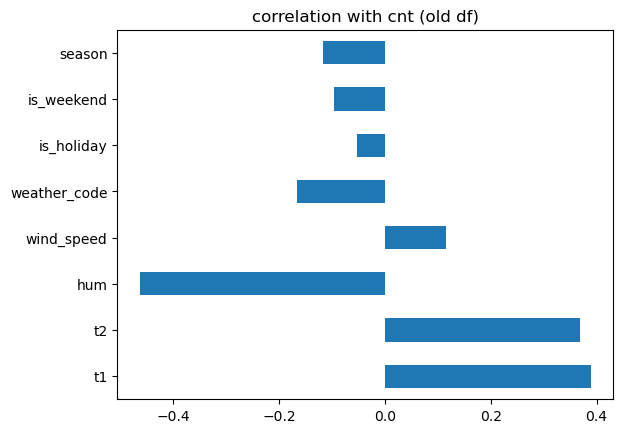

In [11]:
bike_sharing.iloc[:,2:].corrwith(bike_sharing.cnt).plot\
.barh(title='correlation with cnt (old df)',)

<Axes: title={'center': 'correlation with cnt (new df)'}>

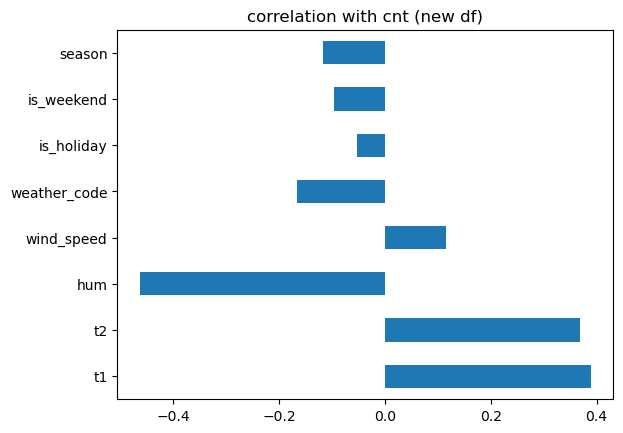

In [12]:
new_bike_sharing.iloc[:,2:].corrwith(new_bike_sharing.cnt).plot\
.barh(title='correlation with cnt (new df)',)

In [13]:
def plot_series(time, series, format="-", start=0, end=None, title='',legend=None):

    plt.figure(figsize=(10, 6))
    
    if type(series) is tuple:
        for series_num in series:
            plt.plot(time[start:end], series_num[start:end], format)
        plt.legend(legend)
    else:
        plt.plot(time[start:end], series[start:end], format)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    plt.show()

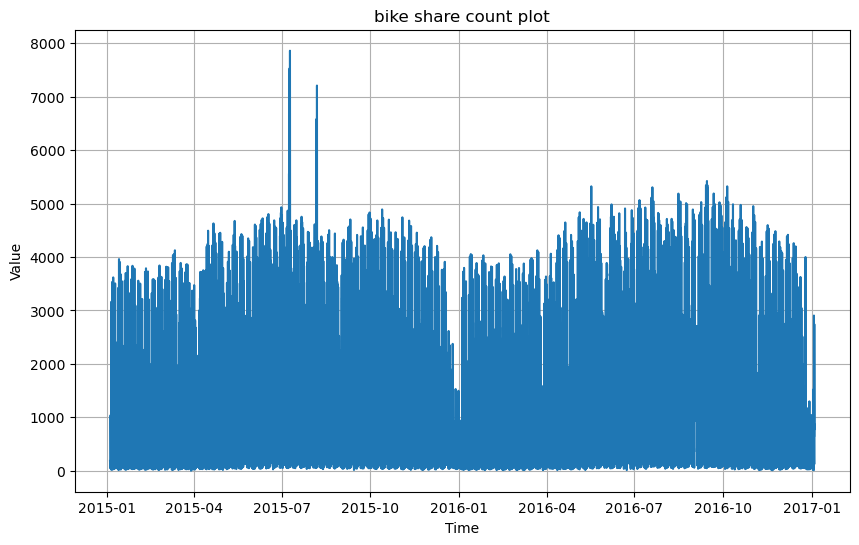

In [14]:
plot_series(new_bike_sharing.timestamp, new_bike_sharing.cnt, title='bike share count plot')

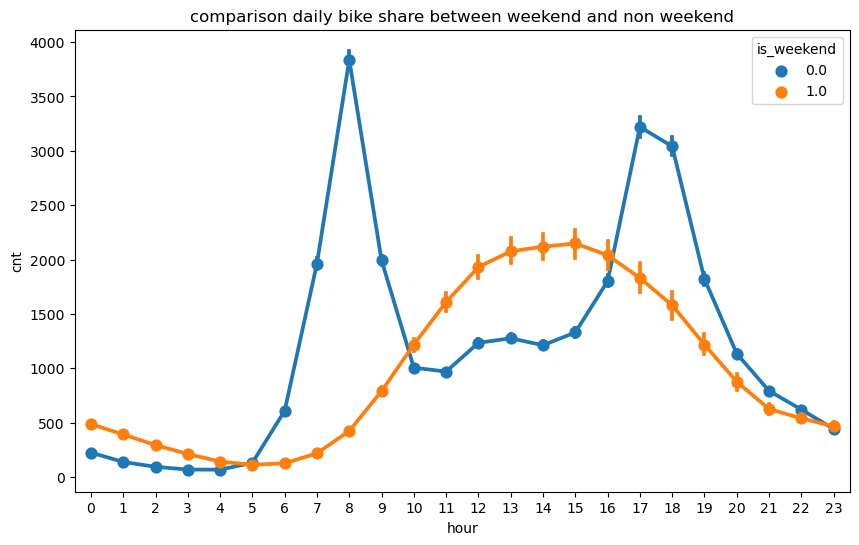

In [15]:
plt.figure(figsize=(10, 6))
ax = sns.pointplot(x=new_bike_sharing.timestamp.dt.hour, y='cnt',hue='is_weekend',data=new_bike_sharing)
ax.set_title("comparison daily bike share between weekend and non weekend")
ax.set_xlabel("hour")
ax.set_ylabel('cnt')
plt.show()

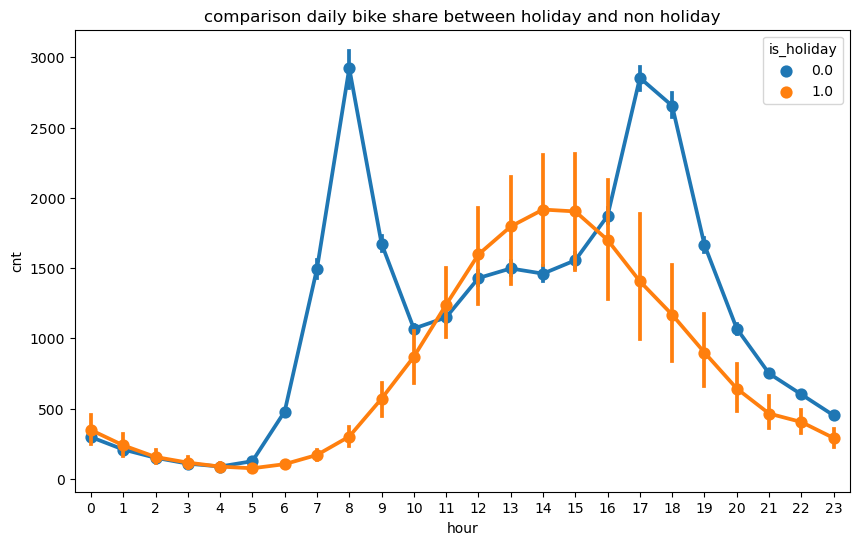

In [16]:
plt.figure(figsize=(10, 6))
ax = sns.pointplot(x=new_bike_sharing.timestamp.dt.hour, y='cnt',hue='is_holiday',data=new_bike_sharing)
ax.set_title("comparison daily bike share between holiday and non holiday")
ax.set_xlabel("hour")
ax.set_ylabel('cnt')
plt.show()

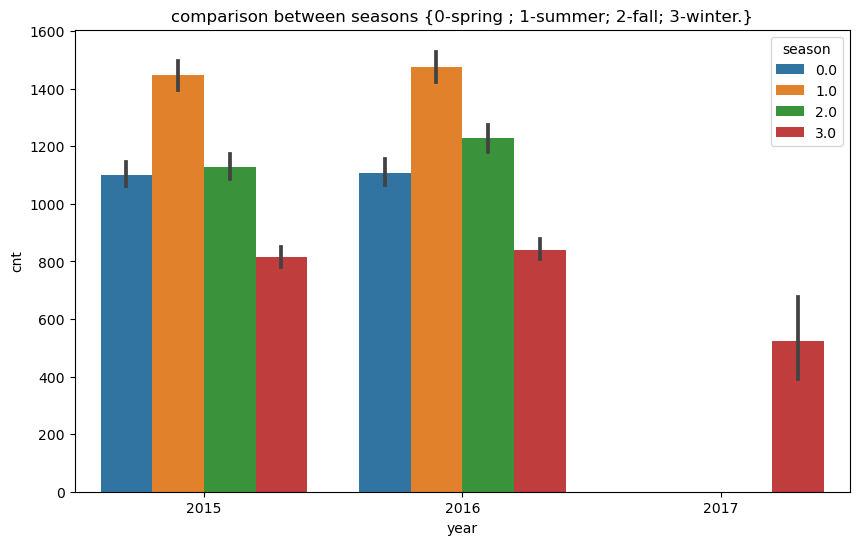

In [17]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=new_bike_sharing.timestamp.dt.year, y='cnt',hue='season',data=new_bike_sharing)
ax.set_title("comparison between seasons {0-spring ; 1-summer; 2-fall; 3-winter.}")
ax.set_xlabel("year")
ax.set_ylabel('cnt')
plt.show()

# Preparing Data

split the data for training and testing

In [18]:
split = int(len(new_bike_sharing) * .8)
train_df = new_bike_sharing[:split]
test_df = new_bike_sharing[split:]

creating object for series datasets

In [19]:
class Data:pass
class SeriesDataset:
    def __init__(self,train_df,test_df,features=[], window_size = 24, batch_size=32):
        self.window_size = window_size 
        self.batch_size =  batch_size
        kwargs = {
            'features': features,
            'label':'cnt',
            'window_size' : self.window_size,
            'batch_size' : self.batch_size,
        }
       
        self.train_dataset = self.windowed_dataset(train_df,shuffle_buffer=10000,**kwargs)
        self.test_dataset = self.windowed_dataset(test_df,**kwargs)
    
    def windowed_dataset(self, df, 
                         features, 
                         label=None,  
                         window_size=30, 
                         shift=1, 
                         batch_size=32, 
                         shuffle_buffer=None):
        
        if label is not None:
            dataset_x = tf.data.Dataset.from_tensor_slices(df[features])
            dataset_y = tf.data.Dataset.from_tensor_slices(df[label])
            dataset_x = dataset_x.window(window_size +1 , shift=1, drop_remainder=True)
            dataset_x = dataset_x.flat_map(lambda window: window.batch(window_size+1))
            dataset_x = dataset_x.map(lambda window: window[:-1])
            dataset =  tf.data.Dataset.zip((dataset_x,dataset_y))
        else :
            dataset = tf.data.Dataset.from_tensor_slices(df[features])
            dataset = dataset.window(window_size + 1 , shift=1, drop_remainder=True)
            dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
            dataset = dataset.map(lambda window: (window[:-1],window[-1]))
        
        if shuffle_buffer is not None:
            dataset = dataset.shuffle(shuffle_buffer)
        dataset = dataset.batch(batch_size).prefetch(1)
    
        return dataset

In [20]:
features = ['t1', 't2', 'hum']
n_features = len(features)
series = SeriesDataset(train_df, test_df,features, batch_size=64)
#dataset for second model
cnt_train = series.windowed_dataset(train_df,'cnt',window_size=24, batch_size=64)
cnt_test = series.windowed_dataset(test_df,'cnt',window_size=24, batch_size=64)

# Modelling

In [21]:
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense,Normalization, BatchNormalization

input_1 = Input(shape=(series.window_size,n_features), name='windowed_features_input')
input_2 = Input(shape=(series.window_size,1), name='windowed_series_input')

norm = Normalization(name='norm')(input_1)

bidirectional_1 = Bidirectional(LSTM(64, activation='relu',name='LSTM1'),name='Bidirectional1')(norm)
bidirectional_2 = Bidirectional(LSTM(64, activation='relu',name='LSTM2'),name='Bidirectional2')(input_2)

x1 = Dense(512,activation='relu',name='dense_1.1')(bidirectional_1)
x1 = Dense(512,activation='relu',name='dense_1.2')(x1)

x2 = Dense(512,activation='relu',name='dense_2.1')(bidirectional_2)
x2 = Dense(512,activation='relu',name='dense_2.2')(x2)

output_1 = Dense(1, activation='linear',name='prediction1')(x1)
output_2 = Dense(1, activation='linear',name='prediction2')(x2)

model1 = tf.keras.Model(inputs=[input_1], outputs=[output_1], name='model_1')
model2 = tf.keras.Model(inputs=[input_2], outputs=[output_2], name='model_2')

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 windowed_features_input (In  [(None, 24, 3)]          0         
 putLayer)                                                       
                                                                 
 norm (Normalization)        (None, 24, 3)             7         
                                                                 
 Bidirectional1 (Bidirection  (None, 128)              34816     
 al)                                                             
                                                                 
 dense_1.1 (Dense)           (None, 512)               66048     
                                                                 
 dense_1.2 (Dense)           (None, 512)               262656    
                                                                 
 prediction1 (Dense)         (None, 1)                 513 

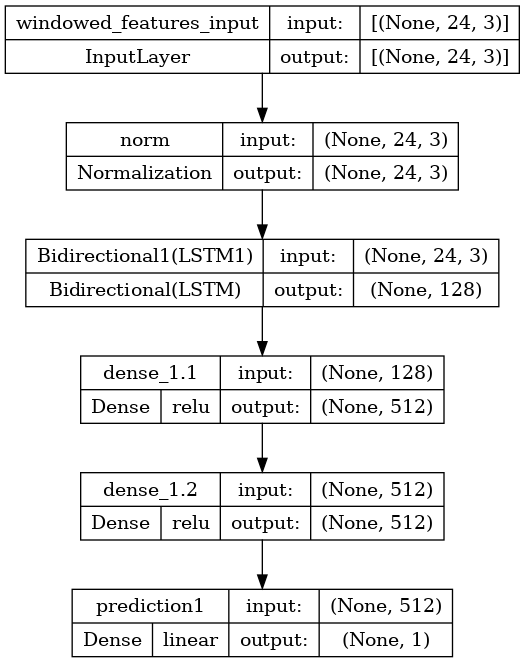

In [22]:
model1.summary()
tf.keras.utils.plot_model(model1, show_shapes=True, show_layer_names=True,show_layer_activations=True)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 windowed_series_input (Inpu  [(None, 24, 1)]          0         
 tLayer)                                                         
                                                                 
 Bidirectional2 (Bidirection  (None, 128)              33792     
 al)                                                             
                                                                 
 dense_2.1 (Dense)           (None, 512)               66048     
                                                                 
 dense_2.2 (Dense)           (None, 512)               262656    
                                                                 
 prediction2 (Dense)         (None, 1)                 513       
                                                                 
Total params: 363,009
Trainable params: 363,009
Non-trainab

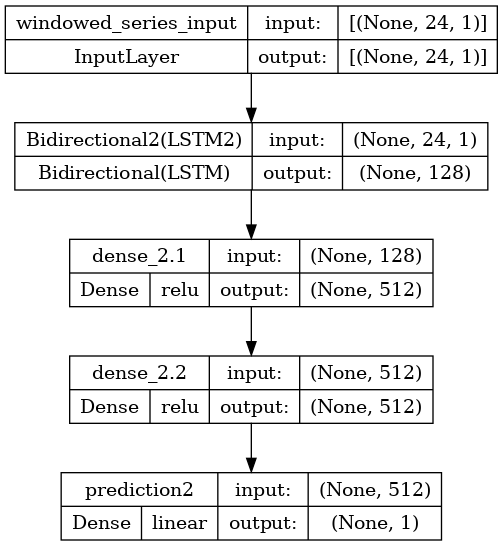

In [23]:
model2.summary()
tf.keras.utils.plot_model(model2, show_shapes=True, show_layer_names=True,show_layer_activations=True)

# Training

defining callbacks

In [24]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    min_delta=0,
    patience=30,
    verbose=2,
    restore_best_weights=True,
)

lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='loss',
        factor=0.1,
        patience=5,
        min_lr=1e-8,
        verbose=0,
        min_delta=0,
    )

callbacks = [early_stop,lr_reduce]

In [25]:
model1.compile(loss='huber', optimizer='adam',metrics=['mse'])
model1.fit(series.train_dataset,
           callbacks=callbacks,
           epochs=150,
           validation_data=series.test_dataset
          )

Epoch 1/150
219/219 [==============================] - 12s 35ms/step - loss: 697.3146 - mse: 1035173.8750 - val_loss: 738.1450 - val_mse: 1242059.7500 - lr: 0.0010
Epoch 2/150
219/219 [==============================] - 8s 30ms/step - loss: 604.9431 - mse: 866675.0625 - val_loss: 623.5529 - val_mse: 997578.9375 - lr: 0.0010
Epoch 3/150
219/219 [==============================] - 7s 29ms/step - loss: 563.9149 - mse: 793973.2500 - val_loss: 573.8662 - val_mse: 905021.0625 - lr: 0.0010
Epoch 4/150
219/219 [==============================] - 8s 29ms/step - loss: 549.0529 - mse: 764838.9375 - val_loss: 624.7260 - val_mse: 1014478.1250 - lr: 0.0010
Epoch 5/150
219/219 [==============================] - 8s 31ms/step - loss: 536.3039 - mse: 741055.2500 - val_loss: 565.2802 - val_mse: 880262.0625 - lr: 0.0010
Epoch 6/150
219/219 [==============================] - 7s 29ms/step - loss: 525.1969 - mse: 723322.0000 - val_loss: 559.3991 - val_mse: 872180.1875 - lr: 0.0010
Epoch 7/150
219/219 [=========

In [26]:
model2.compile(loss='huber', optimizer='adam',metrics=['mse'])
model2.fit(cnt_train,
           callbacks=callbacks,
           epochs=150,
           validation_data=cnt_test
          )

Epoch 1/150
219/219 [==============================] - 11s 36ms/step - loss: 476.8544 - mse: 545474.1250 - val_loss: 402.5495 - val_mse: 424726.1562 - lr: 0.0010
Epoch 2/150
219/219 [==============================] - 8s 35ms/step - loss: 337.2637 - mse: 303789.7188 - val_loss: 328.7484 - val_mse: 319441.9688 - lr: 0.0010
Epoch 3/150
219/219 [==============================] - 7s 33ms/step - loss: 347.1513 - mse: 331821.3750 - val_loss: 323.1509 - val_mse: 296333.8750 - lr: 0.0010
Epoch 4/150
219/219 [==============================] - 7s 33ms/step - loss: 323.9576 - mse: 293514.3125 - val_loss: 385.9866 - val_mse: 365914.3125 - lr: 0.0010
Epoch 5/150
219/219 [==============================] - 7s 32ms/step - loss: 432.5041 - mse: 466740.4062 - val_loss: 479.9165 - val_mse: 557404.0000 - lr: 0.0010
Epoch 6/150
219/219 [==============================] - 7s 34ms/step - loss: 418.5957 - mse: 440343.2188 - val_loss: 382.4196 - val_mse: 420833.8750 - lr: 0.0010
Epoch 7/150
219/219 [============

# Evaluation using test data

55/55 [==============================] - 1s 15ms/step - loss: 522.4859 - mse: 770780.4375


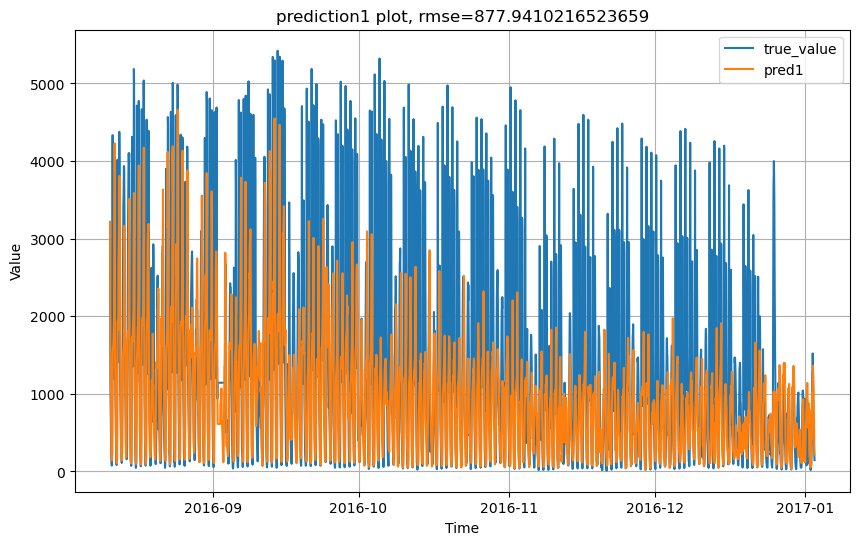

In [27]:
pred1 = model1.predict(series.test_dataset)
loss, mse = model1.evaluate(series.test_dataset)
rmse1 = np.sqrt(mse)
plot_series(test_df.iloc[:-series.window_size].timestamp, (test_df.iloc[:-series.window_size].cnt, pred1), 
            legend=['true_value','pred1'],
            title=f'prediction1 plot, rmse={rmse1}')

55/55 [==============================] - 1s 14ms/step - loss: 182.3751 - mse: 115413.7891


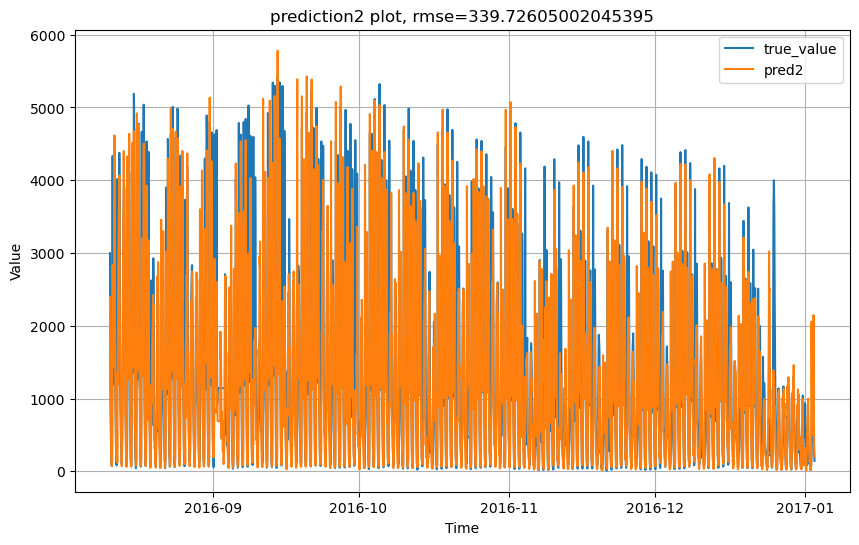

In [28]:
pred2 = model2.predict(cnt_test)
loss, mse = model2.evaluate(cnt_test)
rmse2 = np.sqrt(mse)
plot_series(test_df.iloc[:-series.window_size].timestamp, (test_df.iloc[:-series.window_size].cnt, pred2), 
            legend=['true_value','pred2'],
            title=f'prediction2 plot, rmse={rmse2}')

we will only use model2 next because it perform much better

In [29]:
#function for zooming prediction 2 plot

def zoom_plot(zoom_value):
    start = int((len(test_df) - series.window_size) * zoom_value)

    is_weekend = test_df.iloc[:-series.window_size].is_weekend * 2000
    plot_series(test_df.iloc[:-series.window_size].timestamp, 
                (test_df.iloc[:-series.window_size].cnt, pred2, is_weekend), 
                legend=['true_value','pred2','is_weekend'],
                title=f'prediction2 plot, rmse={rmse2}',
                start=start,
                end=start + 24*7
               )

zooming with slider widget

In [30]:
import ipywidgets as wg

slider = wg.FloatSlider(value=0, min=0, max=1,step=0.01, description='zoom ')

wg.interact(zoom_plot, zoom_value=slider)

interactive(children=(FloatSlider(value=0.0, description='zoom ', max=1.0, step=0.01), Output()), _dom_classes…

<function __main__.zoom_plot(zoom_value)>

# Forecasting

IntProgress(value=0, max=168)

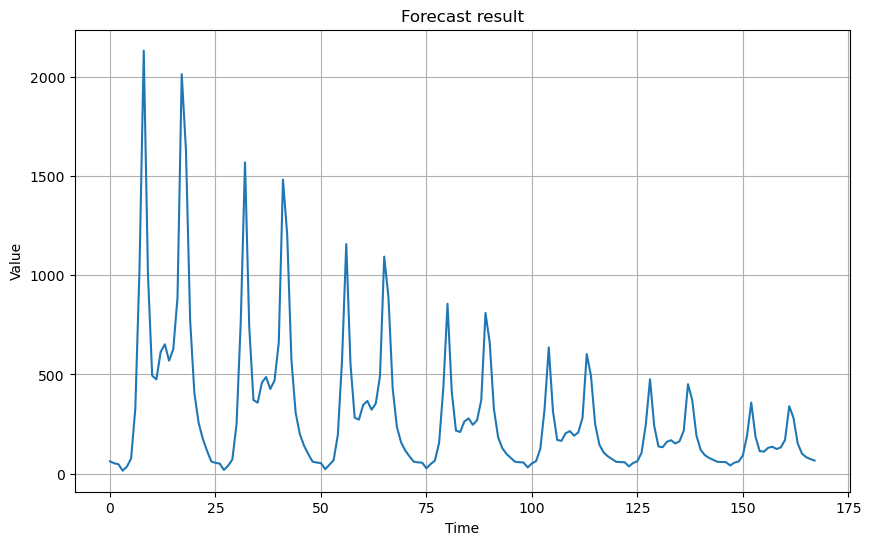

interactive(children=(FloatSlider(value=0.0, description='zoom ', max=6.0, step=1.0), Output()), _dom_classes=…

<function __main__.zoom_plot(zoom_value)>

In [31]:
from ipywidgets import IntProgress
from IPython.display import display


init_x = list(new_bike_sharing.iloc[-24:].cnt.values)
predict_range = 24 * 7 #predict next week
predictions = []

#progress bar
progress = IntProgress(min=0, max=predict_range) 
display(progress) 

for i in range(predict_range):
    pred = model2.predict(np.array(init_x[-24:]).reshape(24,1), verbose=0)
    pred = list(pred[0])
    init_x.extend(pred)
    predictions.extend(pred)
    progress.value += 1

plot_series(list(range(predict_range)), 
                predictions, 
                title='Forecast result',
               )

def zoom_plot(zoom_value):
    start = int(24 * zoom_value)
    plot_series(list(range(predict_range)), 
                predictions, 
                title='Zoomed Forecast result',
                start=start,
                end=start + 24
               )
slider = wg.FloatSlider(value=0, min=0, max=6,step=1.0, description='zoom ')
wg.interact(zoom_plot, zoom_value=slider)